# DML ATE Example

This notebook covers scenario:
| Is RCT        | Treatment | Outcome    | EDA | Estimands | Refutation |
|---------------|-----------|------------|-----|-----------|------------|
| Observational | Binary    | Continuous | Yes | ATE       | Yes        |

We will estimate Average Treatment Effect (ATE) of binary treatment on continuous outcome. It shows explonatary data analysis and refutation tests

## Generate data

Let's generate data of how feature (Treatment) impact on ARPU (Outcome) with linear effect (theta) = 1.8

In [2]:
from causalis.data.dgps import obs_linear_26_dataset

causal_data = obs_linear_26_dataset()

In [3]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from causalis.data import CausalDatasetGenerator, CausalData
#
# # Reproducibility
# np.random.seed(42)
#
# confounder_specs = [
#     {"name": "tenure_months", "dist": "normal", "mu": 24, "sd": 12},
#     {"name": "avg_sessions_week", "dist": "normal", "mu": 5, "sd": 2},
#     {"name": "spend_last_month", "dist": "uniform", "a": 0, "b": 200},
#     {"name": "premium_user", "dist": "bernoulli", "p": 0.25},
#     {"name": "urban_resident", "dist": "bernoulli", "p": 0.60},
# ]
#
# # Causal effect and noise
# theta = 1.8  # ATE: +1.8 ARPU units if new_feature = 1
# sigma_y = 3.5  # ARPU noise std
# target_d_rate = 0.2  # ~20% treated
#
# # Effects of confounders on ARPU (baseline, additive)
# # Order: tenure_months, avg_sessions_week, spend_last_month, premium_user, urban_resident
# beta_y = np.array([
#     0.05,  # tenure_months: small positive effect
#     0.40,  # avg_sessions_week: strong positive effect
#     0.02,  # spend_last_month: recent spend correlates with ARPU
#     2.00,  # premium_user: premium users have higher ARPU
#     1.00,  # urban_resident: urban users slightly higher ARPU
# ], dtype=float)
#
# # Effects of confounders on treatment assignment (log-odds scale)
# beta_d = np.array([
#     0.015,  # tenure_months
#     0.10,  # avg_sessions_week
#     0.002,  # spend_last_month
#     0.75,  # premium_user
#     0.30,  # urban_resident: more likely to get the feature
# ], dtype=float)
#
# gen = CausalDatasetGenerator(
#     theta=theta,
#     outcome_type="continuous",
#     sigma_y=sigma_y,
#     target_d_rate=target_d_rate,
#     seed=42,
#     confounder_specs=confounder_specs,
#     beta_y=beta_y,
#     beta_d=beta_d,
# )
#
#
# # Create dataset
# causal_data = gen.to_causal_data(
#     n=10_000,
#     confounders = [
#     "tenure_months",
#     "avg_sessions_week",
#     "spend_last_month",
#     "premium_user",
#     "urban_resident",
# ]
# )
#
# # Show first few rows
# causal_data.df.head()


## EDA


In [4]:
from causalis.eda import CausalEDA
eda = CausalEDA(causal_data)

# shape of data
eda.data_shape()

{'n_rows': 10000, 'n_columns': 7}

### General dataset information

Let's see how outcome differ between clients who recieved the feature and didn't

In [5]:
# 1) Outcome statistics by treatment
eda.outcome_stats()

,count,mean,std,min,p10,p25,median,p75,p90,max
treatment,,,,,,,,,,
0.0,8030,6.137433,3.933863,-9.866447,1.118291,3.517427,6.157583,8.847907,11.114776,20.770359
1.0,1970,8.608973,3.942856,-3.821492,3.666892,5.986613,8.560912,11.247429,13.552612,21.377687


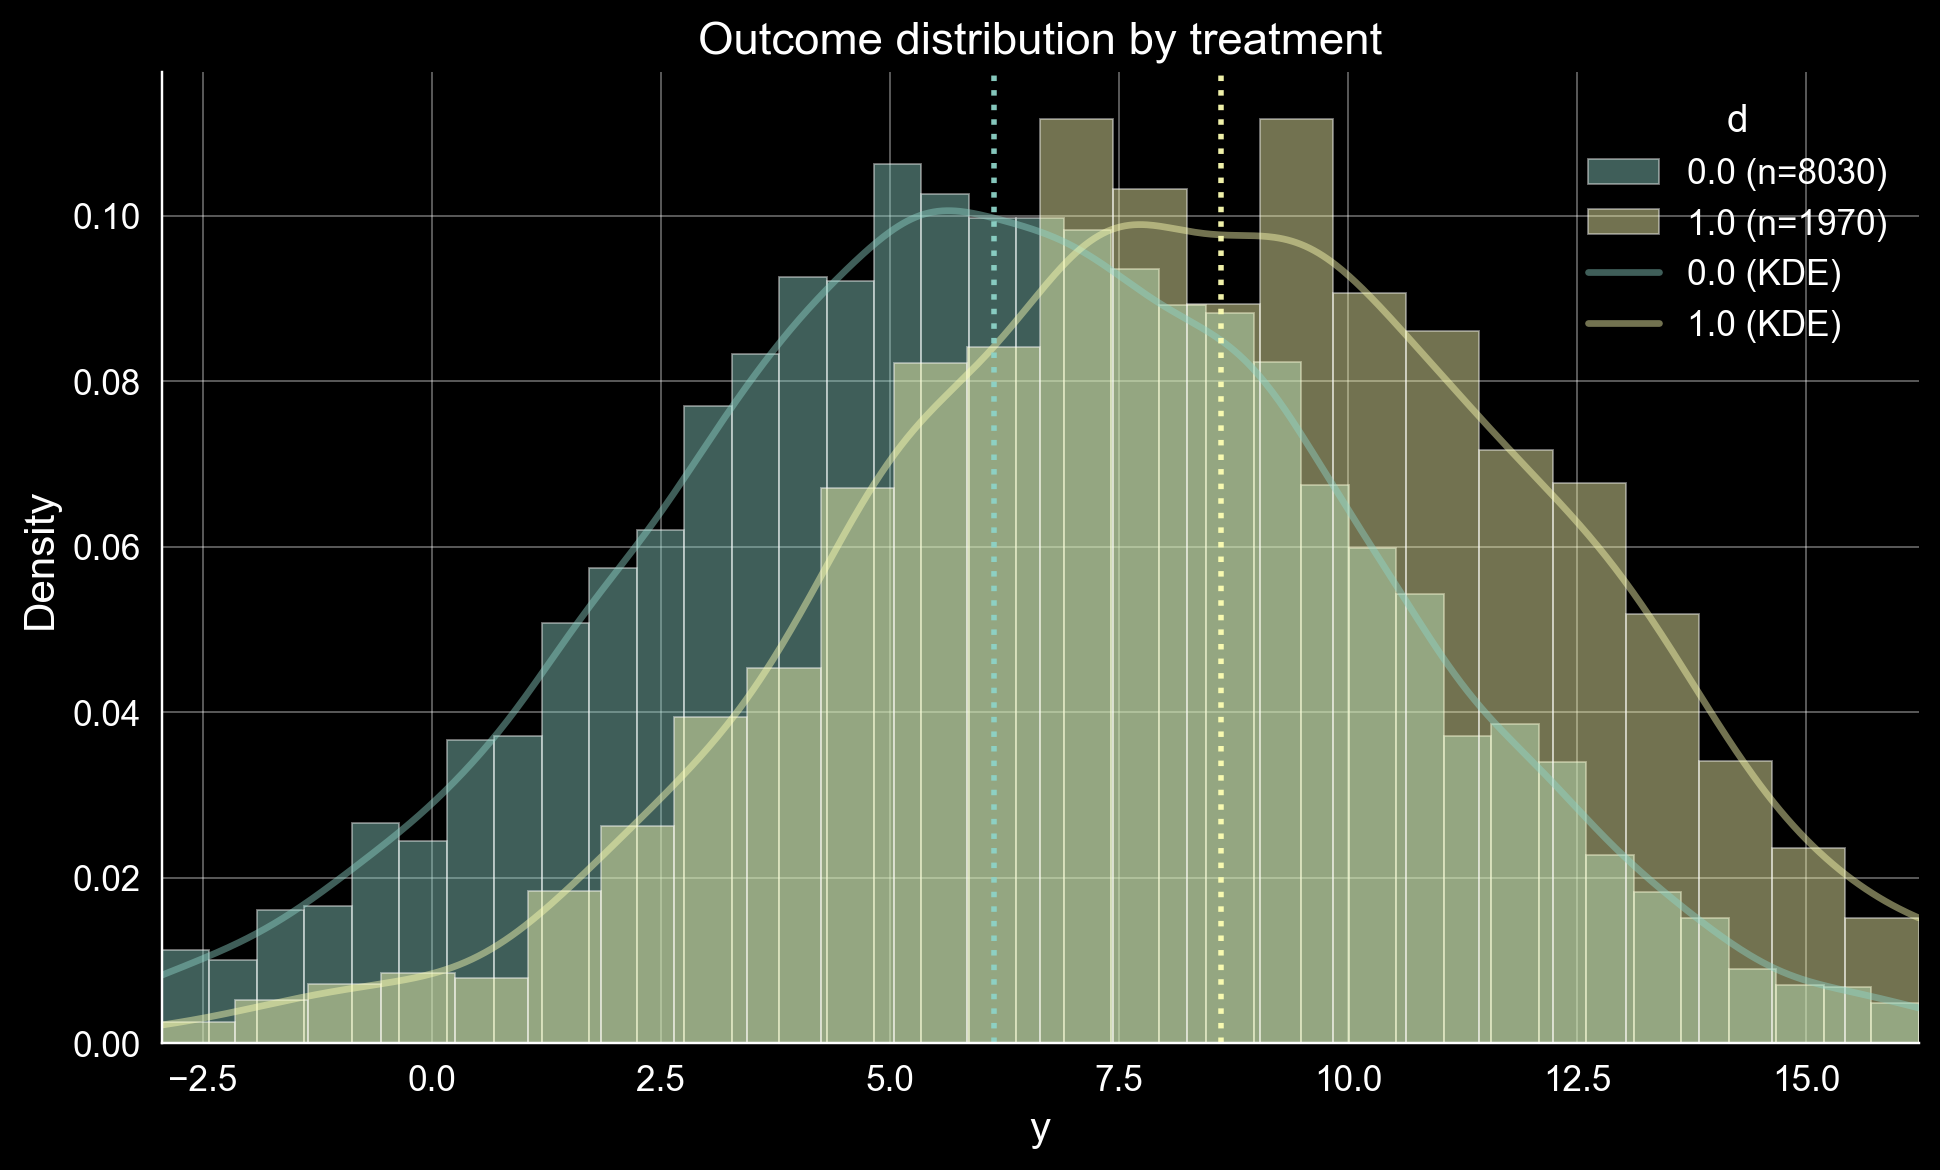

In [6]:
eda.outcome_hist()

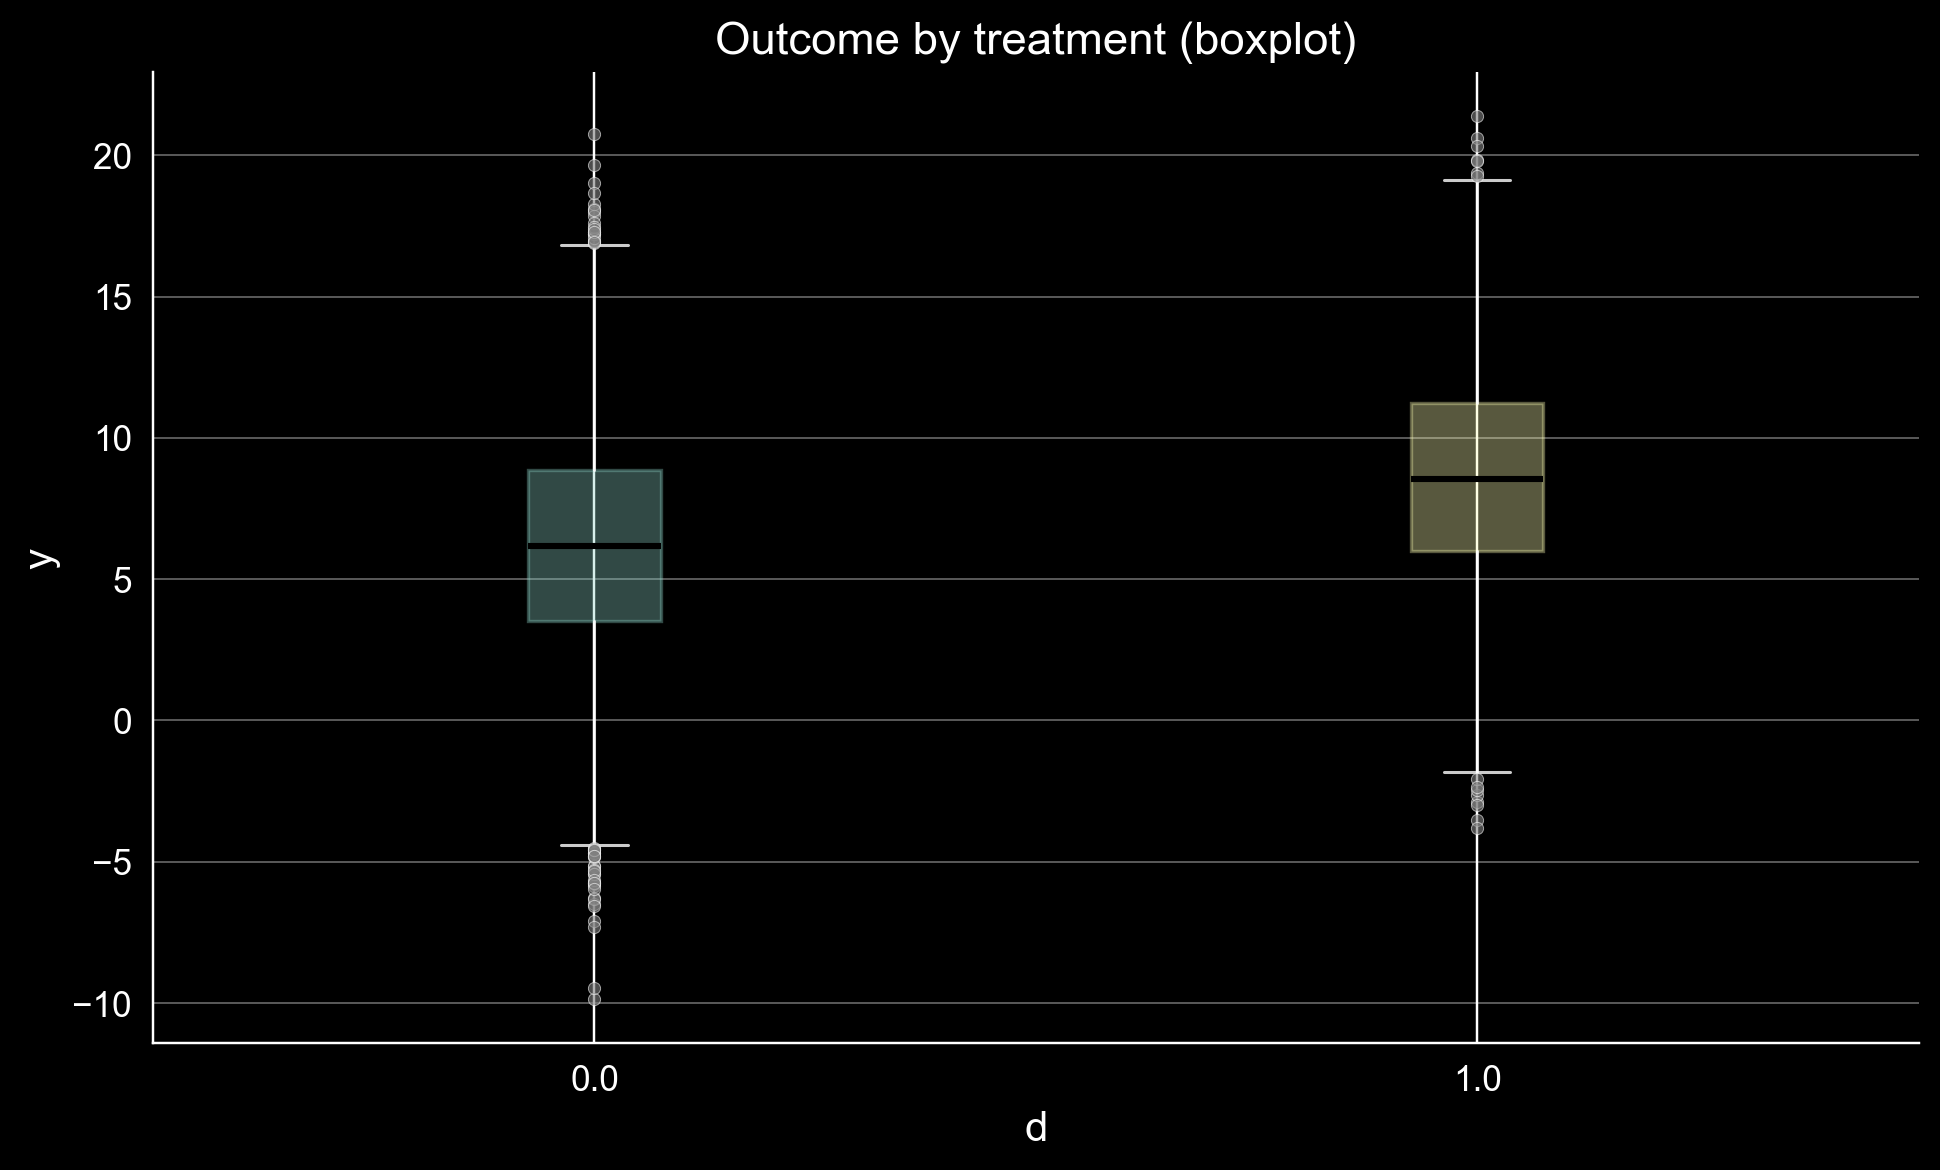

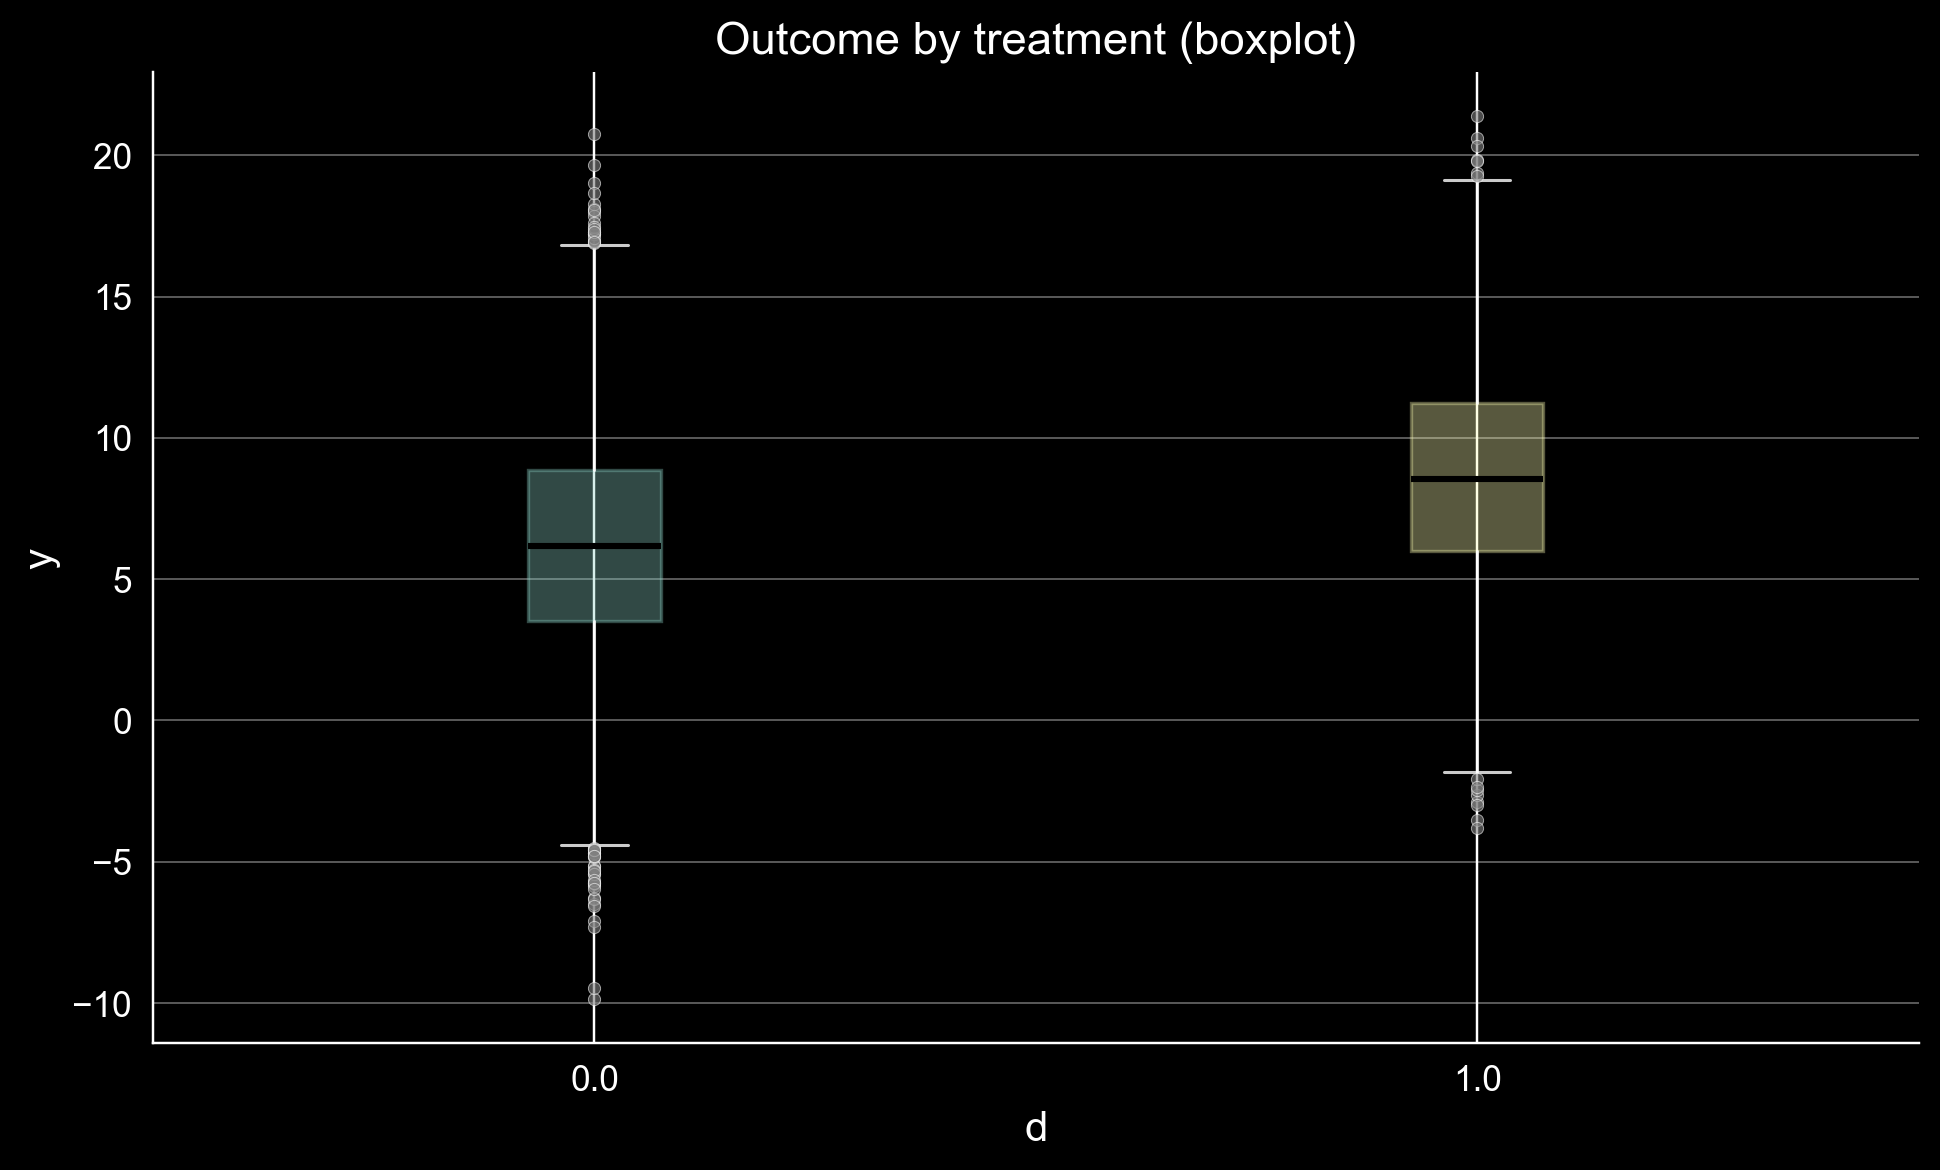

In [7]:
eda.outcome_boxplot()

### Propensity

Now let's examine how propensity score differ treatments

In [8]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

,mean_t_0,mean_t_1,abs_diff,smd,ks,ks_pvalue
confounders,,,,,,
premium_user,0.218057,0.382234,0.164176,0.364037,0.164176,1.061599e-37
tenure_months,23.405355,25.799499,2.394143,0.199024,0.087485,5.511096e-11
avg_sessions_week,4.976354,5.302999,0.326645,0.163509,0.075782,2.382131e-08
urban_resident,0.587547,0.655330,0.067783,0.140072,0.067783,9.127269e-07
spend_last_month,99.288113,104.941250,5.653137,0.097172,0.057348,5.761025e-05


In [9]:
# Propensity model fit
ps_model = eda.fit_propensity()

# ROC AUC - shows how predictable treatment is from confounders
roc_auc_score = ps_model.roc_auc
print("ROC AUC from PropensityModel:", round(roc_auc_score, 4))

ROC AUC from PropensityModel: 0.5926


In [10]:
# Positivity check - assess overlap between treatment groups
positivity_result = ps_model.positivity_check()
print("Positivity check from PropensityModel:", positivity_result)

Positivity check from PropensityModel: {'bounds': (0.05, 0.95), 'share_below': 0.0121, 'share_above': 0.0, 'flag': False}


In [11]:
# SHAP values - feature importance for treatment assignment from confounders
shap_values_df = ps_model.shap
display(shap_values_df)

,feature,shap_mean,shap_mean_abs,exact_pp_change_abs,exact_pp_change_signed
0,num__spend_last_month,0.000299,0.166002,0.027438,0.000047
1,num__premium_user,-0.000269,0.306301,0.052687,-0.000042
2,num__urban_resident,0.000245,0.158900,0.026210,0.000039
3,num__avg_sessions_week,-0.000141,0.174082,0.028841,-0.000022
4,num__tenure_months,-0.000135,0.194878,0.032482,-0.000021


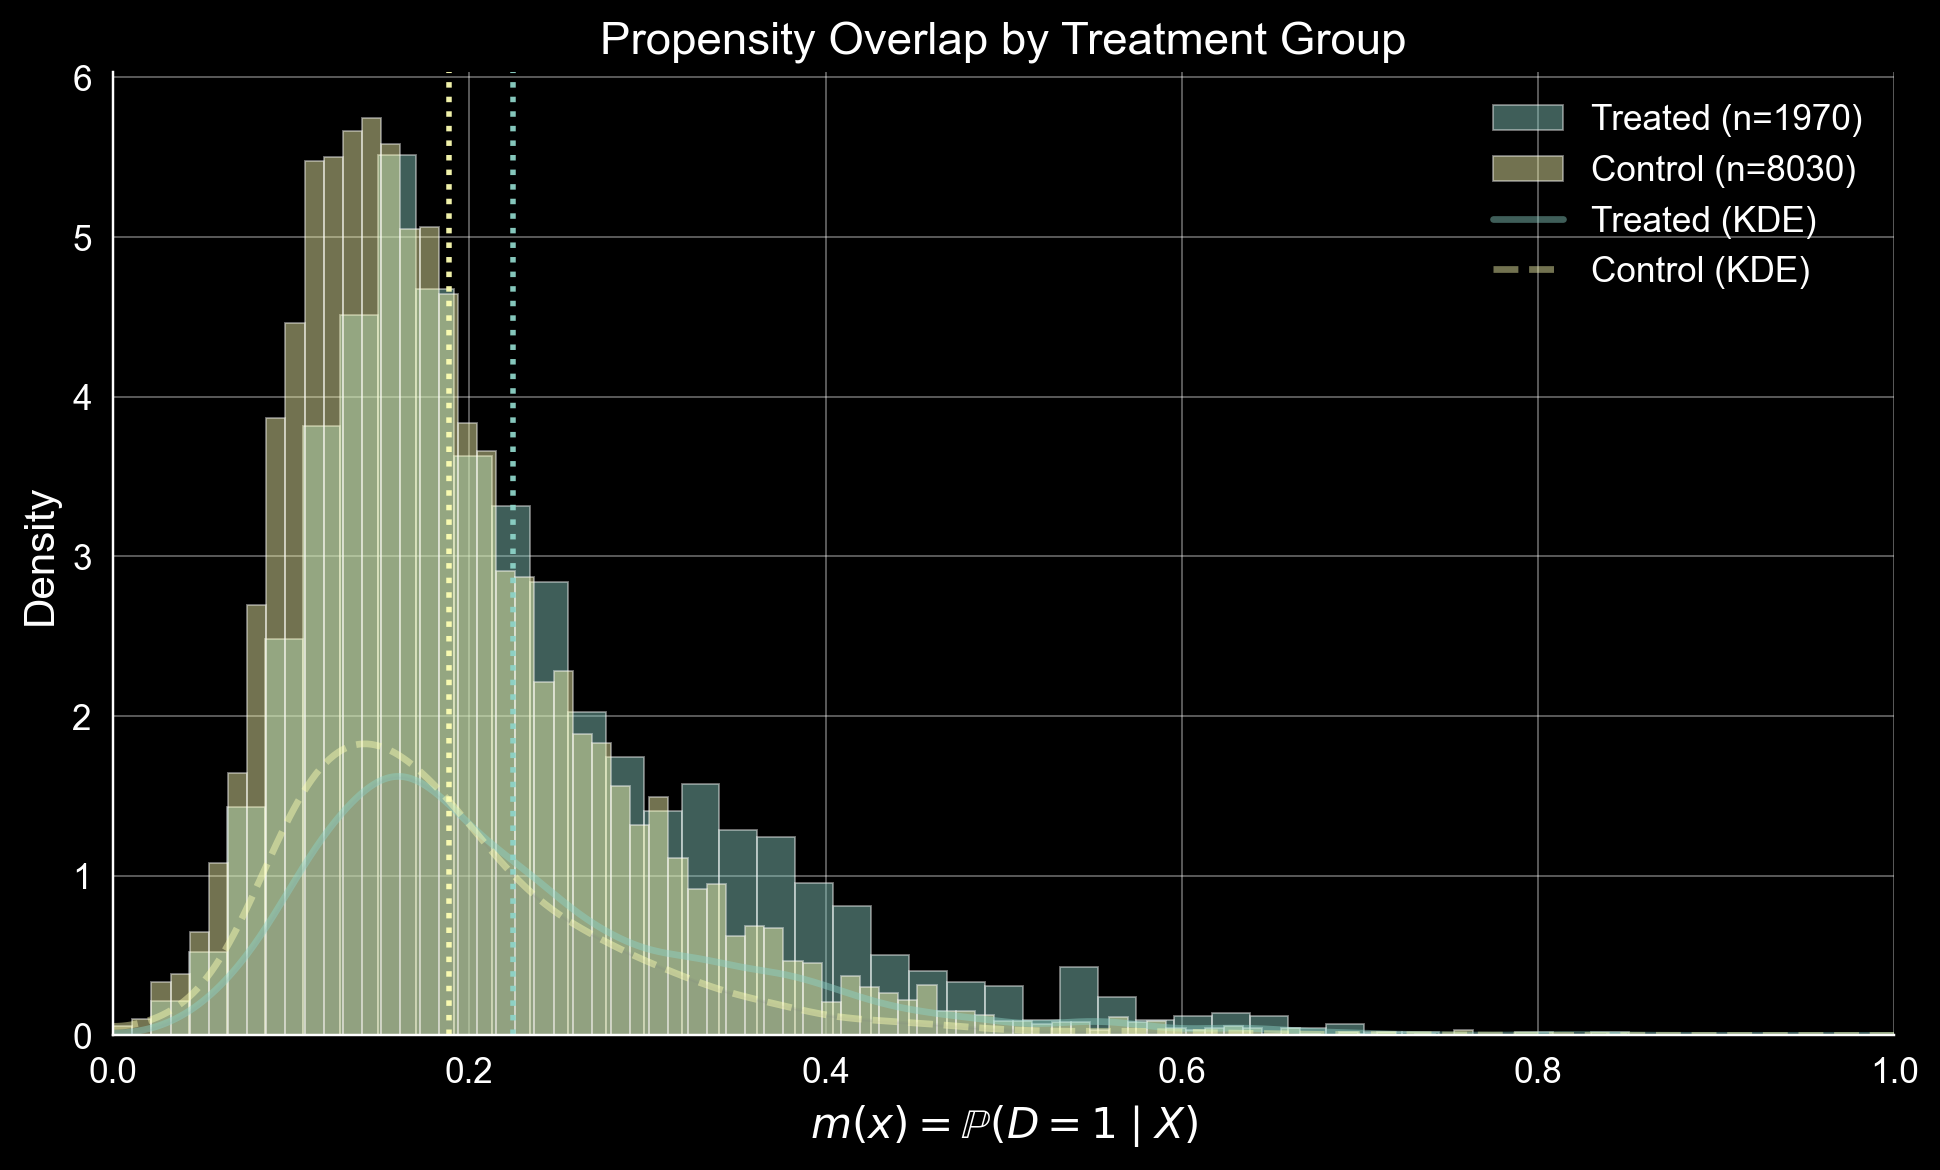

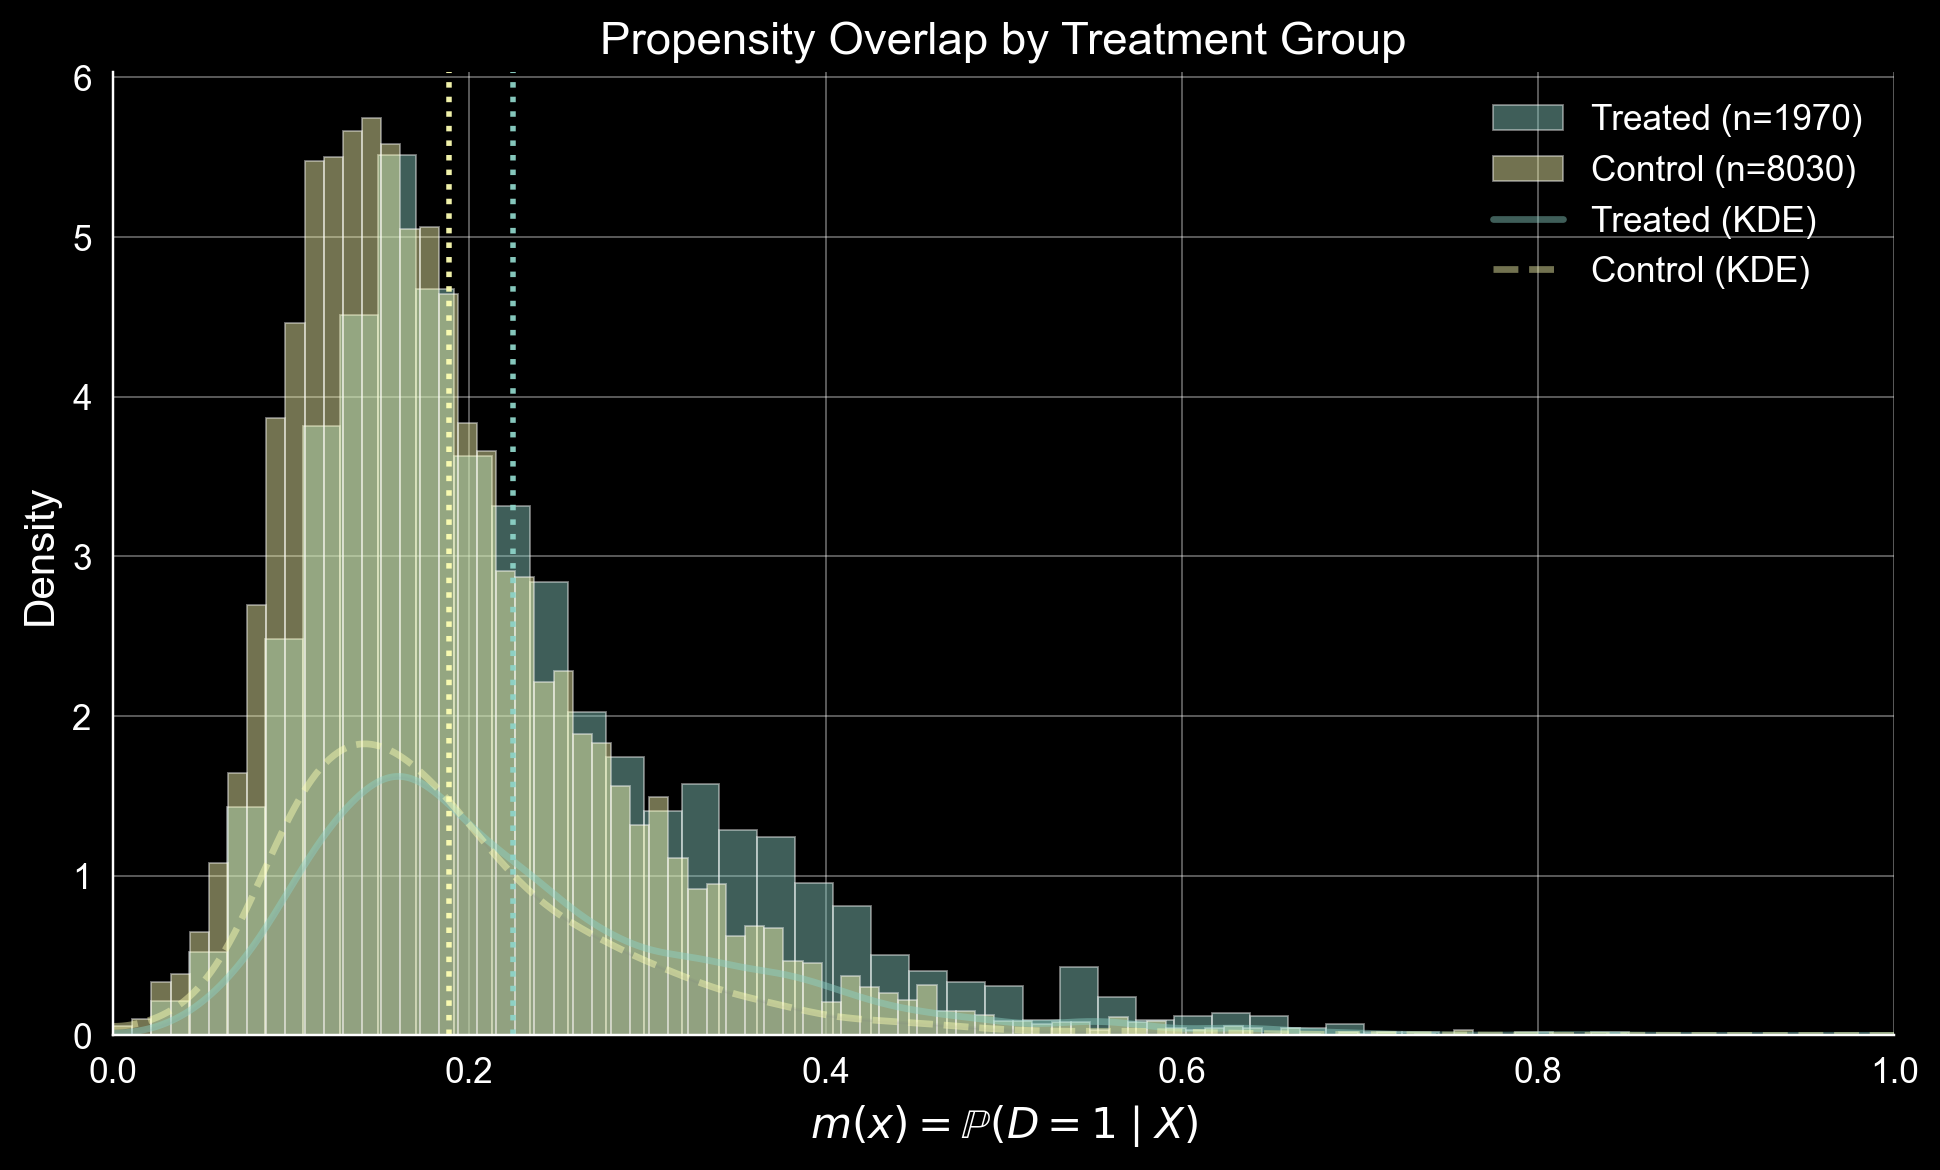

In [12]:
# Propensity score overlap graph
ps_model.plot_m_overlap()

### Outcome regression

Let's analyze how confounders predict outcome

In [13]:
# Outcome model fit
outcome_model = eda.outcome_fit()

# RMSE and MAE of regression model
print(outcome_model.scores)

{'rmse': 3.656989617205263, 'mae': 2.90424413216463}


In [14]:
# 2) SHAP values - feature importance for outcome prediction from confounders
shap_outcome_df = outcome_model.shap
display(shap_outcome_df)

,feature,shap_mean
0,avg_sessions_week,-0.000502
1,spend_last_month,0.000350
2,urban_resident,0.000245
3,premium_user,-0.000055
4,tenure_months,-0.000038


## Inference

Now time to estimate ATE with Double Machine Learning

In [15]:
from causalis.inference.ate import dml_ate

# Estimate Average Treatment Effect (ATE)
ate_result = dml_ate(causal_data, n_folds=4, confidence_level=0.95)

In [16]:
print(ate_result.get('coefficient'))
print(ate_result.get('p_value'))
print(ate_result.get('confidence_interval'))

1.7549660401689693
0.0
(1.522668837019938, 1.9872632433180006)


True theta in our data generating proccess was 1.8

## Refutation

### Overlap

In [15]:
from  causalis.refutation import *
rep = run_overlap_diagnostics(res=ate_result)
rep["summary"]

,metric,value,flag
0,edge_0.01_below,0.000000,GREEN
1,edge_0.01_above,0.000000,GREEN
2,edge_0.02_below,0.001000,GREEN
3,edge_0.02_above,0.000000,GREEN
4,KS,0.139672,GREEN
5,AUC,0.592382,GREEN
6,ESS_treated_ratio,0.742224,GREEN
7,ESS_control_ratio,0.970455,GREEN
8,tails_w1_q99/med,6.278831,GREEN
9,tails_w0_q99/med,2.844508,GREEN


### Score

In [16]:
from causalis.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(res=ate_result)
rep_score["summary"]

,metric,value,flag
0,se_plugin,1.190252e-01,NA
1,psi_p99_over_med,1.355647e+01,YELLOW
2,psi_kurtosis,6.047594e+01,RED
3,max_|t|_g1,5.463687e+00,RED
4,max_|t|_g0,1.384511e+00,GREEN
5,max_|t|_m,1.388284e+00,GREEN
6,oos_tstat_fold,1.241609e-15,GREEN
7,oos_tstat_strict,1.241615e-15,GREEN


### SUTVA

In [17]:
print_sutva_questions()

1.) Are your clients independent (i)?
2.) Do you measure cofounders, treatment, and outcome in the same intervals?
3.) Do you measure cofounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


## Uncofoundedness

In [18]:
from causalis.refutation.uncofoundedness.uncofoundedness_validation import run_uncofoundedness_diagnostics

rep_uc = run_uncofoundedness_diagnostics(res=ate_result)
rep_uc['summary']

,metric,value,flag
0,balance_max_smd,0.021956,GREEN
1,balance_frac_violations,0.000000,GREEN


In [19]:
from causalis.refutation.uncofoundedness.sensitivity import (
    sensitivity_analysis, sensitivity_benchmark
)

sensitivity_analysis(ate_result, cf_y=0.01, cf_d=0.01, rho=1.0, level=0.95)

{'theta': 1.766253520771568,
 'se': 0.11902521860734187,
 'level': 0.95,
 'z': 1.959963984540054,
 'sampling_ci': (1.5329683790491713, 1.9995386624939646),
 'theta_bounds_cofounding': (1.6875916811818483, 1.8449153603612876),
 'bias_aware_ci': (1.4543065394594517, 2.0782005020836842),
 'max_bias': 0.07866183958971962,
 'sigma2': 13.136641553423134,
 'nu2': 0.43676740621591587,
 'params': {'cf_y': 0.01, 'cf_d': 0.01, 'rho': 1.0, 'use_signed_rr': False}}

In [20]:
sensitivity_benchmark(ate_result, benchmarking_set =['tenure_months'])

,cf_y,cf_d,rho,theta_long,theta_short,delta
d,0.000034,3.037675e-07,-1.0,1.766254,1.845679,-0.079425
